# LeNet 5 Pytorch Implementation

Research Paper Link :- https://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

![LeNet5 Architecture](https://upload.wikimedia.org/wikipedia/commons/3/35/LeNet-5_architecture.svg)

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

##  Define LeNet-5 Model Architecture

In [ ]:
# Model definition created each layer of the network
class LeNet5(nn.Module):
    def __init__(self):
        # calling module init to insitialize all pytorch usefull variables 
        super(LeNet5, self).__init__()
        # here the model is defined in a functional way (not sequential)
        # we use input channel as 1 (gray scale) and output 6 as number of features 
        # with padding = 2 the output remain the same of the input 
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)  # (28x28 -> 28x28)
        self.relu = nn.ReLU() # activation 
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # (28x28 -> 14x14)
        # we have again 6 channels input 
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # (14x14 -> 10x10)

        #linear layers (fully connected)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # definition of the sequence of feed forward through the defined layers 
        # concatenation of layers defined to forward the input through the network
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool

        x = x.view(-1, 16 * 5 * 5)  # Flatten (based on previous layers size)
        
        x = self.relu(self.fc1(x))  # Fully Connected Layer 1 -> ReLU
        x = self.relu(self.fc2(x))  # Fully Connected Layer 2 -> ReLU
        x = self.fc3(x)  # Fully Connected Layer 3 (Output)
        
        return x

## Hyperparameters

In [3]:
# training parameters to define 
batch_size = 64
epochs = 10
learning_rate = 0.001

## Data Loading and Transformation

In [ ]:
# Loading and Transformation for pytorch training
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) 
# the numbers used are the mean and std dev specific to MNIST dataset (keep center around zero)

# loading mnist dataset, applying the transformation pipeline + normalizationand so on... 
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader is used for efficient training.. In order to set up batch size and other training hyperparameters 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 278kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.03MB/s]


## Model, Loss, and Optimizer

In [ ]:
# properly define the model and move to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
# cross entropy loss + Adam optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Model Training & Evaluation

In [ ]:
# Training Loop
# work on top of the data loader for training 

# we store losses and accuracies for future check 
train_losses, test_accuracies = [], []
for epoch in range(epochs):
    # set in train mode 
    model.train()
    running_loss = 0.0 # initialize loss
    # iterate over training data 
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # move to GPU if available 
        optimizer.zero_grad() # Don't accumulate the gradient otherwise the previous batch will interfer with the current one. 
        outputs = model(images)
        loss = criterion(outputs, labels)
        # backward propagation for optimization of the weights 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # average loss over the batch and store it 
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    # Evaluation (visualize online during training the performance on the test set)
    model.eval()
    # to compute number of correct prediction
    correct, total = 0, 0
    with torch.no_grad(): # speed up inference with no_grad option
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            # count number of preditcions correct and accumulate 
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Accuracy on test set: {accuracy:.2f}%')

# Pytorch give you more control and flexibility on your model training 

Epoch [1/10], Loss: 0.3063
Accuracy on test set: 96.00%
Epoch [2/10], Loss: 0.0855
Accuracy on test set: 97.88%
Epoch [3/10], Loss: 0.0574
Accuracy on test set: 98.43%
Epoch [4/10], Loss: 0.0456
Accuracy on test set: 98.69%
Epoch [5/10], Loss: 0.0373
Accuracy on test set: 98.77%
Epoch [6/10], Loss: 0.0318
Accuracy on test set: 99.02%
Epoch [7/10], Loss: 0.0287
Accuracy on test set: 98.92%
Epoch [8/10], Loss: 0.0239
Accuracy on test set: 98.87%
Epoch [9/10], Loss: 0.0208
Accuracy on test set: 98.93%
Epoch [10/10], Loss: 0.0186
Accuracy on test set: 99.03%


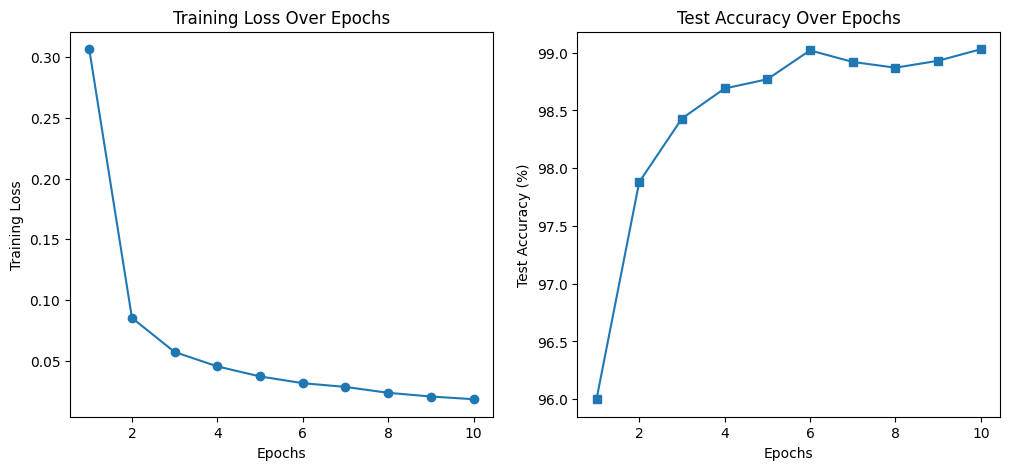

In [ ]:
# Plot Accuracy and Loss
# Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')

# Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), test_accuracies, marker='s', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.show()

# As expeted the Loss decrease while the Accuracy increases

In [ ]:
# Inference Function to use the model 
# to feed forward any ne winput on the model 
def predict_image(image):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # Add batch dimension
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()



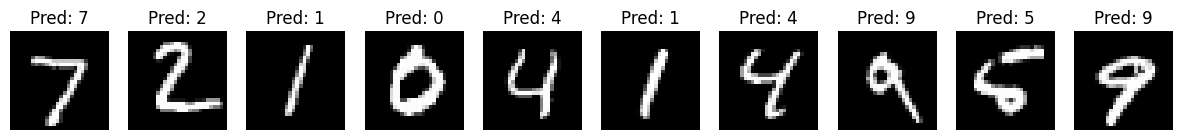

In [9]:
# Visualizing Predictions
samples, labels = next(iter(test_loader))
samples, labels = samples.to(device), labels.to(device)
predictions = [predict_image(img) for img in samples[:10]]

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.imshow(samples[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f'Pred: {predictions[i]}')
    ax.axis('off')
plt.show()